In [1]:
import numpy as np
import numpy.linalg as LA

In [2]:
srho = 0.25**2
spsi = 0.0436**2
alpha = 0.05

## Questão 1

In [3]:
def lp2lc(coords) -> np.array:
    rho, psi = coords
    return np.array([
        [rho*np.cos(psi)],
        [rho*np.sin(psi)],
    ])

def Q_lp2lc(obs) -> np.array:
    rho, psi = obs
    return np.array([
        [rho**2 * spsi * np.sin(psi)**2 + srho * np.cos(psi)**2, 0.5*(-rho**2 * spsi + srho)*np.sin(2*psi)],
        [0.5*(-rho**2 * spsi + srho)*np.sin(2*psi), rho**2 * spsi * np.cos(psi)**2 + srho * np.sin(psi)**2]
    ])

## Questão 2

In [4]:
def R_lc2g(theta: float) -> np.array:
    '''
    Rotation matrix from Local Cartesiano to Global
    '''
    return np.array([
            [ np.cos(theta),-np.sin(theta)],
            [ np.sin(theta), np.cos(theta)]
    ])

def A_lc2g(robot: np.array) -> np.array:
    '''
    Homogenous matrix from Local Cartesiano to Global
    '''    
    x, y, theta = robot
    return np.array([
        [ np.cos(theta), -np.sin(theta), x],
        [ np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

def lc2g(coords_lc: np.array, robot: np.array) -> np.array:
    x_lc, y_lc = coords_lc
    return (A_lc2g(robot) @ np.array([[x_lc[0]], [y_lc[0]], [1]]))[:2]

def Q_lc2g(theta: float, Q_lc: np.array) -> np.array:
    return R_lc2g(theta) @ Q_lc @ R_lc2g(theta).T

## Questão 3

In [5]:
def g2lc(coords_g: np.array, robot: np.array) -> np.array:
    A_g2lc = LA.inv(A_lc2g(robot))
    gx, gy = coords_g
    return (A_g2lc @ np.array([[gx], [gy], [1]]))[:2]

def C(theta):
    return R_lc2g(theta).T

def lc2lp(coords_lc: np.array) -> np.array:
    l, r = coords_lc
    return np.array([
        [np.sqrt(l**2+r**2)],
        [np.arctan2(r,l)]
    ])

## Questão 4

In [6]:
def check_sensor(x: float, y: float, theta_robot: float = np.pi/6) -> bool:
    print(f'X: {x}   Y: {y}')
    D_MAX = 3
    ANG_MAX = np.pi/3
    x_robot = 1
    y_robot = 2
    l, r = g2lc([x,y], [x_robot, y_robot, theta_robot])
    rho, psi = lc2lp([l,r])
    print(rho,psi)
    
    if rho <= D_MAX and (-ANG_MAX <= psi) and (psi <= ANG_MAX):
        print(True,'\n')
    else:
        print(False,'\n')

In [7]:
check_sensor(2,2)

X: 2   Y: 2
[[1.]] [[-0.52359878]]
True 



## Questão 5

In [8]:
def Lj(land, obs, robot_t):
    '''
    land = [mu, sigma]
    mu = [x_bar, y_bar]
    obs = [rho, psi]
    '''
    return C(robot_t[2]) @ land['sigma'] @ C(robot_t[2]).T + Q_lp2lc(obs)
    
def W(observations_t, landmarks, robot_t):
    '''
    Observations = todas as obs de um mesmo timestamp
    '''
    m = len(landmarks)
    n = len(observations_t)
    W = np.empty((n,m))
    for i, obs in enumerate(observations_t):
        for j, land in enumerate(landmarks):
            d = lp2lc(obs) - g2lc(land['mu'], robot_t)
            L = Lj(land, obs, robot_t)
            W[i][j] = 1 / np.sqrt(2*np.pi*LA.det(L)) * np.exp(-(d.T @ LA.inv(L) @ d)/2)
        
    return W

def attribute_landmarks(W, observations_t, robot_t):
    c = []
    new_landmarks = []
    n, m = W.shape
    while True:
        i,j = np.unravel_index(np.argmax(W), W.shape)
        max_W = np.max(W)
        if max_W == -1:
            break
        elif max_W >= alpha:
            c.append({'observation':i, 'landmark': j, 'weight': max_W})
            W[i,:] = -1
            W[:,j] = -1
        else:
            #create new landmark
            obs = observations_t[i]
            initial_mu = lc2g(lp2lc(obs), robot_t)
            initial_sigma = Q_lc2g(robot_t[2], Q_lp2lc(obs))
            new_landmarks.append({'mu':initial_mu, 'sigma':initial_sigma})
            c.append({'observation':i, 'landmark': m+len(new_landmarks)-1, 'weight': alpha})
            W[i,:] = -1
    return c, new_landmarks

In [9]:
z1 = [3, 0]
z2 = [4, -0.646] 
z3 = [np.sqrt(2), np.pi/8]
Z = [z1,z2,z3]
Z = np.array(Z)
robot_t = np.array([4, 3, -np.pi/2])
landmarks = [
    [[2,1], [[1/9,0],
             [0,1.]]],
    [[3,-1], [[5/9,4/9],
              [5/9,4/8.]]],
    [[5/2,2], [[1/9,0],
             [0,1.]]],    
]
landmarks = [{'mu':np.array(l[0]), 'sigma':np.array(l[1])} for l in landmarks]

In [10]:
weight_matrix = W(Z, landmarks, robot_t)
c, new_landmarks = attribute_landmarks(weight_matrix, Z, robot_t)
landmarks = landmarks + new_landmarks

In [11]:
c

[{'observation': 0, 'landmark': 1, 'weight': 0.5922766415312831},
 {'observation': 1, 'landmark': 0, 'weight': 0.30677578739611505},
 {'observation': 2, 'landmark': 3, 'weight': 0.05}]

In [12]:
print('Mapa atualizado')
for i, l in enumerate(landmarks):
    print(f'Landmark {i}')
    print(f'mu: {l["mu"]}')
    print(f'sigma: {l["sigma"]}')

Mapa atualizado
Landmark 0
mu: [2 1]
sigma: [[0.11111111 0.        ]
 [0.         1.        ]]
Landmark 1
mu: [ 3 -1]
sigma: [[0.55555556 0.44444444]
 [0.55555556 0.5       ]]
Landmark 2
mu: [2.5 2. ]
sigma: [[0.11111111 0.        ]
 [0.         1.        ]]
Landmark 3
mu: [[4.5411961 ]
 [1.69343704]]
sigma: [[ 0.01239805 -0.02075291]
 [-0.02075291  0.05390387]]


In [13]:
total_weight = 1
for el in c:
    total_weight *= el['weight']
print(f'Peso total: {total_weight}')

Peso total: 0.009084806653104299


## Questão 6

In [15]:
import pandas as pd

In [25]:
data = pd.read_csv('./data/valoresEP2.csv', usecols=np.arange(14), header=None).to_numpy()
control_hist = data[:,:2]
observations = data[:,2:]

In [30]:
def F(X_prev: np.array, u_prev: np.array, dt=1) -> np.array:
    '''
    Calculada analiticamente.
    '''
    l = 0.3
    return np.array([
        X_prev[0] + u_prev[0] * np.cos(u_prev[1]) *  np.cos(X_prev[2]) * dt,
        X_prev[1] + u_prev[0] * np.cos(u_prev[1]) *  np.sin(X_prev[2]) * dt,
        X_prev[2] + u_prev[0] * dt * np.tan(u_prev[1])/ l
    ])

In [31]:
X = [[0,0,0]]
for i, u in enumerate(control_hist):
    X.append(F(X[-1], u))

In [34]:
import matplotlib.pyplot as plt

In [38]:
X = np.array(X)

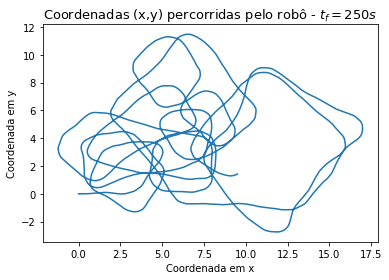

In [39]:
plt.plot(X[:,0], X[:,1])
plt.ylabel('Coordenada em y')
plt.xlabel('Coordenada em x')
plt.title(r'Coordenadas (x,y) percorridas pelo robô - $t_f=250s$', fontsize=13)
plt.savefig('./images/caminhoQ4.png', dpi=600)
plt.show()

In [ ]:
def previsao(df_robot : pd.DataFrame,
             mi_inicial : np.array,
             sigma_inicial : np.array,
             tempo_final : int,
             dt : float,
             l : float) -> (np.array, np.array, np.array, np.array, np.array, np.array)    :
    """
    Realiza o procedimento do filtro de Kalman para cálculo de estimativas sem considerar medições, 
    ou seja, mi = mi_barra e sigma = sigma_barra

    Args:
        df_robot (pd.DataFrame): dataframe que contém os dados do robô
        mi_inicial (np.array): matriz mi para o instante de tempo inicial
        sigma_inicial (np.array): matriz sigma para o instante de tempo inicial
        tempo_final (int): instante de tempo final em segundo
        dt (float): passo de iteração
        l (float): distância entre eixos do veículo

    Returns:
        x (np.array): vetor com coordenada x ao longo das iterações
        y (np.array): vetor com coordenada y ao longo das iterações
        theta (np.array): vetor com ângulo theta do robô com a horizontal ao longo das iterações
        fx (np.array): vetor com campo magnético local na coordenada x ao longo das iterações
        fx (np.array): vetor com campo magnético local na coordenada y ao longo das iterações
        sigma (np.array): matriz sigma no instante tempo_final
    """
    # Quantidade de iterações
    it = int(tempo_final / dt)
    # Estabelecendo variáveis
    x = np.append(np.array(mi_inicial.T[0]), np.zeros(it).T)
    y = np.append(np.array(mi_inicial.T[1]), np.zeros(it).T)
    theta = np.append(np.array(mi_inicial.T[2]), np.zeros(it).T)
    fx = np.append(np.array(mi_inicial.T[3]), np.zeros(it).T)
    fy = np.append(np.array(mi_inicial.T[4]), np.zeros(it).T)
    v = np.array(df_robot['velocidade'])
    phi = np.array(df_robot['phi'])
    tempo = 0

    # Transpondo mi e mi_barra para o python tratar melhor
    mi = np.append(np.array([mi_inicial.T]), np.zeros((5, it)).T, axis=0)
    sigma = sigma_inicial

    for t in range(1, it + 1):
        # Calculando mi e mi_barra
        F = mi[t-1] + [v[t-1]*np.cos(theta[t-1])*dt, 
                          v[t-1]*np.sin(theta[t-1])*dt, 
                          (v[t-1]*np.tan(phi[t-1])*dt) / l, 
                          0, 
                          0]

        # Adicionando novo estado para e mi
        mi[t] = F
        
        # Separando componentes de mi_barra / mi
        x[t] = mi[t][0]
        y[t] = mi[t][1]
        theta[t] = mi[t][2]
        fx[t] = mi[t][3]
        fy[t] = mi[t][4]

        tempo += dt
        
        if tempo == tempo_final:
            print(f"Sigma no instante {tempo}: {sigma}")

    return x, y, theta